# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "w_scale": False, # W boson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [3]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [4]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "sample_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /home/chakkappai/Work/ST4_CS/Collaboration_A



### Add directories to path

In [5]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [6]:
import HiggsML.visualization as visualization
from HiggsML.systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [7]:
from model import Model

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [8]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [9]:
if USE_PUBLIC_DATASET:
    from HiggsML.datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [10]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575097 entries, 0 to 575096
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 72.4 MB
None
[*] Train data loaded successfully


In [11]:
# load test sets
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [12]:
train_visualize = visualization.Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [13]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 575097
[*] --- Number of features : 28
   diboson   2406557.155900697
   htautau   285.4728755059505
   ttbar   616020.9338114334
   wjets   3813046.6129843956
   ztautau   7307433.686247317
[*] --- Number of signal events : 495551
[*] --- Number of background events : 79546
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,45.966999,-1.402,-0.515,68.288002,-0.239,-1.326,92.753998,-2.135,2.038,68.288002,...,134.285004,0.809,-0.000,2.832,1.418,42.035000,307.636993,0.673,1.261,0.516
1,39.028000,-2.145,-2.117,45.306000,-0.918,1.347,45.306000,-0.918,1.347,35.924999,...,26.198999,0.627,17.005,0.267,3.075,32.248001,165.563995,0.861,0.777,0.000
2,39.417999,-1.759,1.631,63.446999,-0.858,-2.262,63.446999,-0.858,-2.262,47.672001,...,51.630001,0.807,-0.000,0.044,2.554,107.933998,213.983994,0.621,1.390,0.000
3,22.764999,-0.470,-0.644,46.081001,-1.816,-0.288,128.972000,-2.479,2.391,65.328003,...,165.546005,0.250,11.882,6.767,1.392,53.011002,336.960999,0.494,1.277,0.000
4,30.077000,0.594,0.522,50.507000,1.614,-2.578,50.507000,1.614,-2.578,-7.000000,...,4.732000,-7.000,-7.000,-7.000,3.263,4.732000,131.091003,0.596,-0.656,-7.000


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,...,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000
mean,41.587288,0.001249,-0.002408,51.980938,0.001700,0.002269,78.830299,0.000010,0.000237,36.990437,...,67.170692,-0.698906,10.923657,-2.100203,2.535986,51.966286,243.089920,0.948967,0.416845,-1.835261
std,25.250553,1.163580,1.813929,28.497721,1.196813,1.813250,60.044243,1.554487,1.813495,41.354321,...,70.612892,4.300686,30.965837,4.097096,0.708182,56.682335,161.085648,0.699222,1.124750,3.401444
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.919001,-4.924000,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.308001,-0.879000,-1.572000,34.564999,-0.914000,-1.566000,43.466999,-1.114000,-1.573000,-7.000000,...,19.063999,-7.000000,-7.000000,-7.000000,2.084000,15.574000,135.878998,0.533000,-0.896000,-7.000000
50%,34.370998,0.001000,-0.006000,45.473000,0.003000,0.008000,58.905998,0.002000,0.001000,34.153999,...,42.243000,0.962000,0.000000,-1.146000,2.756000,32.807999,189.559998,0.771000,1.048000,0.006000
75%,47.387001,0.883000,1.570000,59.839001,0.919000,1.570000,91.196999,1.114000,1.570000,55.606998,...,90.876999,2.385000,15.437000,0.632000,3.069000,70.741997,300.084015,1.132000,1.368000,0.568000
max,1026.430054,2.500000,3.142000,778.645996,2.681000,3.142000,1166.640015,4.924000,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

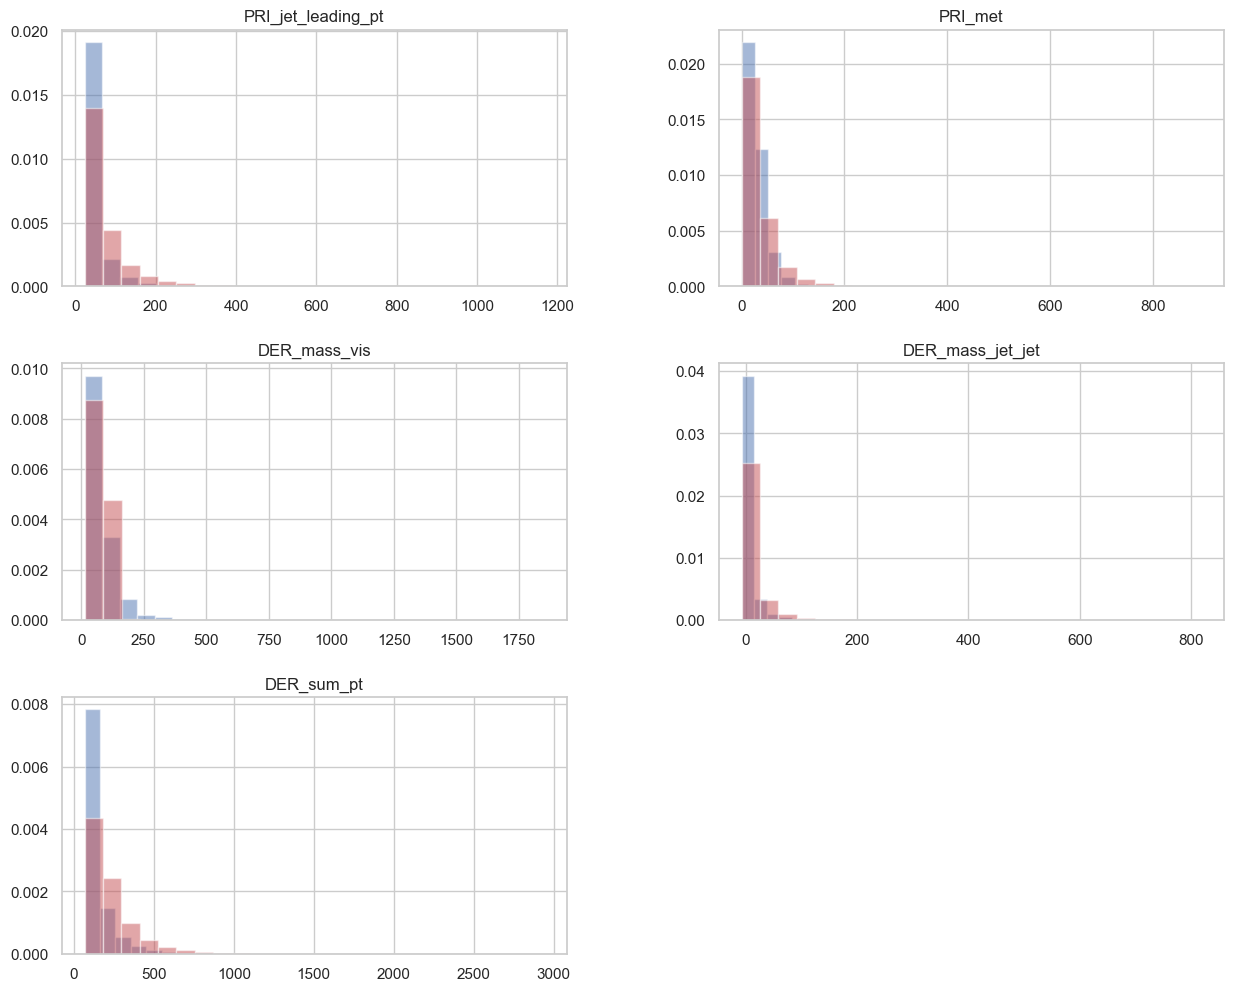

In [14]:
# Show data summary
train_visualize.histogram_dataset()

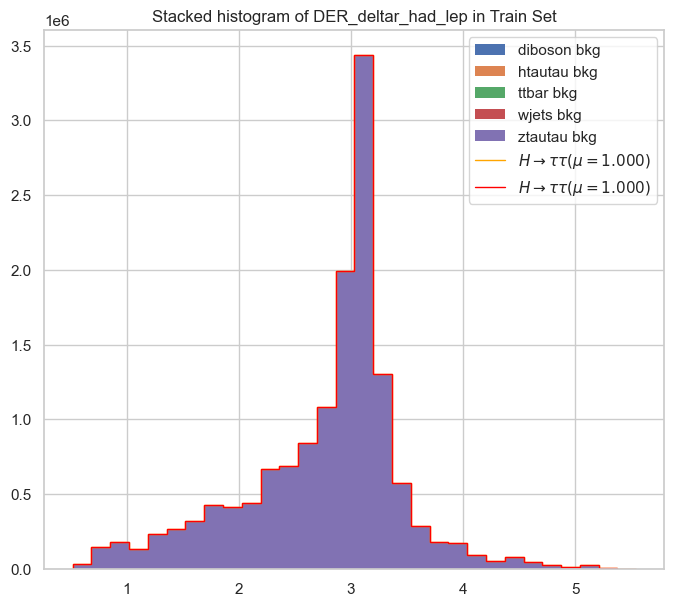

In [15]:
train_visualize.stacked_histogram("DER_deltar_had_lep")

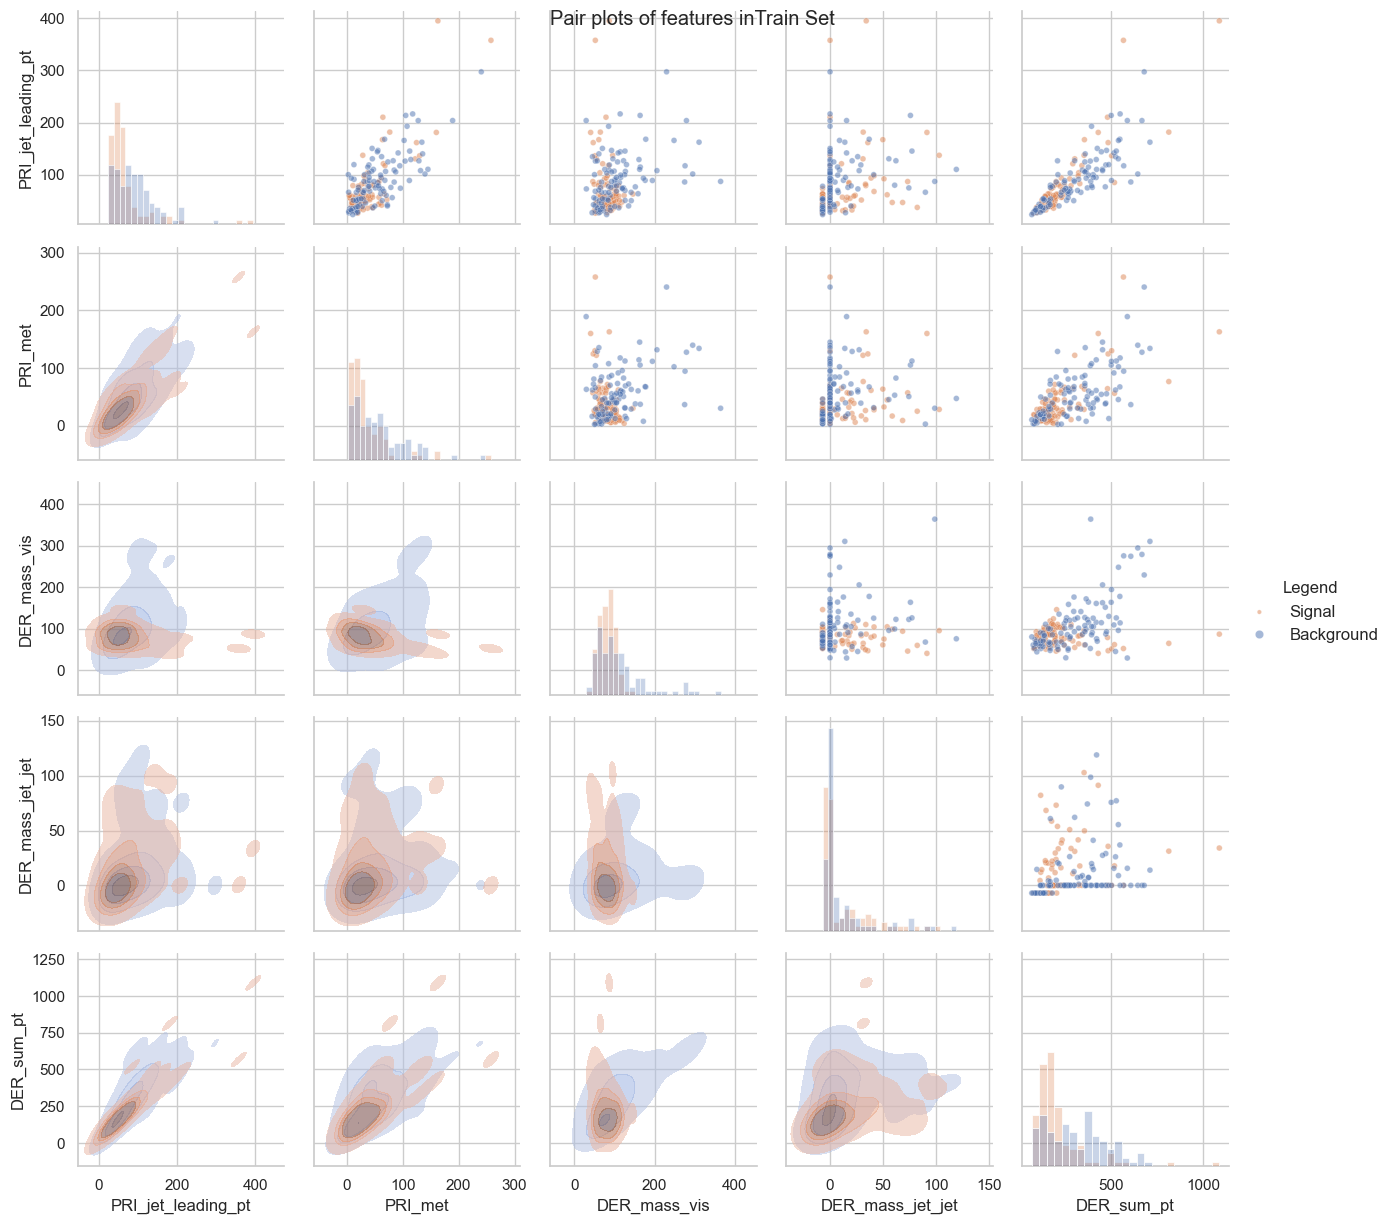

In [16]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [17]:
syst_train_data = data.get_syst_train_set()

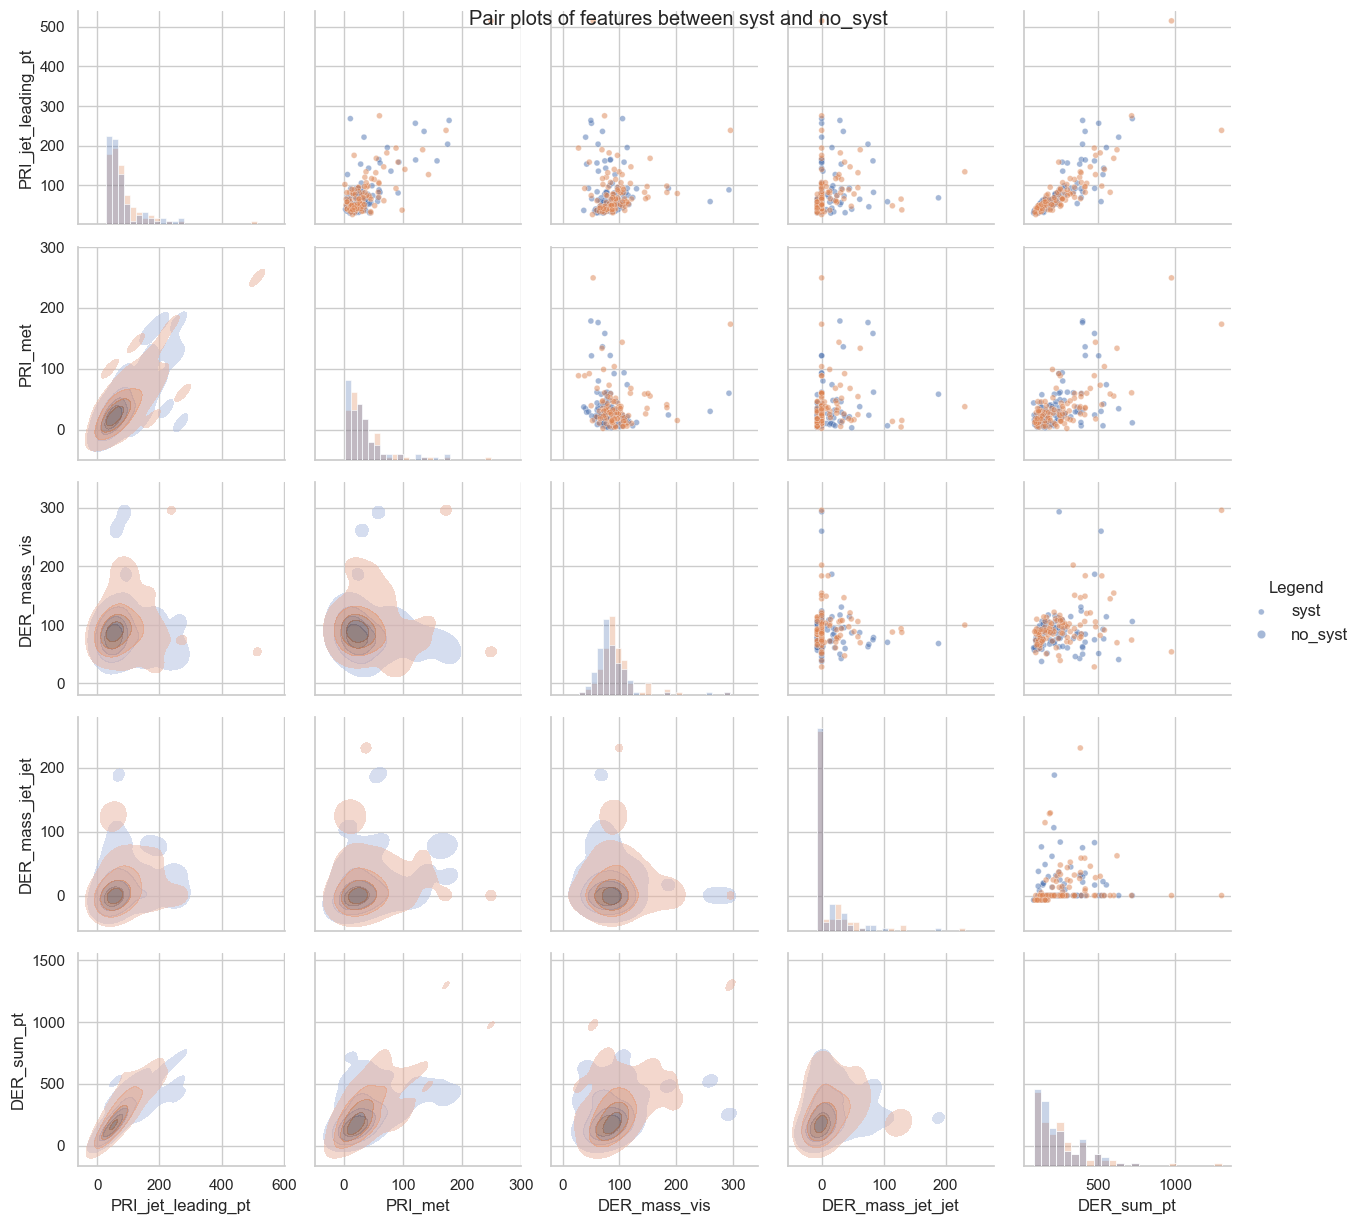

In [18]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [19]:
bootstraped_data = data.generate_psuedo_exp_data()

In [20]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 575097
[*] --- Number of features : 28
   diboson   2406557.155900697
   htautau   285.4728755059505
   ttbar   616020.9338114334
   wjets   3813046.6129843956
   ztautau   7307433.686247317
[*] --- Number of signal events : 495551
[*] --- Number of background events : 79546
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,45.966999,-1.402,-0.515,68.288002,-0.239,-1.326,92.753998,-2.135,2.038,68.288002,...,134.285004,0.809,-0.000,2.832,1.418,42.035000,307.636993,0.673,1.261,0.516
1,39.028000,-2.145,-2.117,45.306000,-0.918,1.347,45.306000,-0.918,1.347,35.924999,...,26.198999,0.627,17.005,0.267,3.075,32.248001,165.563995,0.861,0.777,0.000
2,39.417999,-1.759,1.631,63.446999,-0.858,-2.262,63.446999,-0.858,-2.262,47.672001,...,51.630001,0.807,-0.000,0.044,2.554,107.933998,213.983994,0.621,1.390,0.000
3,22.764999,-0.470,-0.644,46.081001,-1.816,-0.288,128.972000,-2.479,2.391,65.328003,...,165.546005,0.250,11.882,6.767,1.392,53.011002,336.960999,0.494,1.277,0.000
4,30.077000,0.594,0.522,50.507000,1.614,-2.578,50.507000,1.614,-2.578,-7.000000,...,4.732000,-7.000,-7.000,-7.000,3.263,4.732000,131.091003,0.596,-0.656,-7.000


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_n_jets,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,...,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000,575097.000000
mean,41.587288,0.001249,-0.002408,51.980938,0.001700,0.002269,78.830299,0.000010,0.000237,36.990437,...,67.170692,-0.698906,10.923657,-2.100203,2.535986,51.966286,243.089920,0.948967,0.416845,-1.835261
std,25.250553,1.163580,1.813929,28.497721,1.196813,1.813250,60.044243,1.554487,1.813495,41.354321,...,70.612892,4.300686,30.965837,4.097096,0.708182,56.682335,161.085648,0.699222,1.124750,3.401444
min,20.000000,-2.500000,-3.142000,22.861000,-2.686000,-3.142000,22.919001,-4.924000,-3.142000,-7.000000,...,0.041000,-7.000000,-7.000000,-14.626000,0.518000,0.041000,66.679001,0.034000,-1.414000,-7.000000
25%,26.308001,-0.879000,-1.572000,34.564999,-0.914000,-1.566000,43.466999,-1.114000,-1.573000,-7.000000,...,19.063999,-7.000000,-7.000000,-7.000000,2.084000,15.574000,135.878998,0.533000,-0.896000,-7.000000
50%,34.370998,0.001000,-0.006000,45.473000,0.003000,0.008000,58.905998,0.002000,0.001000,34.153999,...,42.243000,0.962000,0.000000,-1.146000,2.756000,32.807999,189.559998,0.771000,1.048000,0.006000
75%,47.387001,0.883000,1.570000,59.839001,0.919000,1.570000,91.196999,1.114000,1.570000,55.606998,...,90.876999,2.385000,15.437000,0.632000,3.069000,70.741997,300.084015,1.132000,1.368000,0.568000
max,1026.430054,2.500000,3.142000,778.645996,2.681000,3.142000,1166.640015,4.924000,3.142000,696.237000,...,1167.008057,7.845000,817.351000,14.638000,5.829000,1797.446045,2939.478027,23.846001,1.414000,1.000000


***
### Program
***


In [21]:

from HiggsML.ingestion import Ingestion

ingestion = Ingestion(data)


In [22]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575097 entries, 0 to 575096
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 72.4 MB
None
[*] Train data loaded successfully


In [23]:

# fit submission
ingestion.fit_submission()

[*] Calling fit method of submitted model


In [24]:

# load test set
data.load_test_set()

[*] Loading Test data
[*] Test data loaded successfully


In [25]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
[*] - mu_hat: 0.0 - del_mu_tot: 3397.678472133583 - del_mu_stat: 3397.678472133583 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3396.009275605707 - del_mu_stat: 3396.009275605707 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3395.9709951647114 - del_mu_stat: 3395.9709951647114 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3340.3017827735266 - del_mu_stat: 3340.3017827735266 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3653.7540968160406 - del_mu_stat: 3653.7540968160406 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3679.515049568353 - del_mu_stat: 3679.515049568353 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3691.4998306921266 - del_mu_stat: 3691.4998306921266 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3509.21486945442 - del_mu_stat: 3509.21486945442 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3715.9242457294527 - del_mu_stat: 3715.9242457294527 - del_mu_sys: 0.0
[*] - mu_hat: 0.0 - del_mu_tot: 3746.

In [26]:
ingestion.compute_result()

[*] Saving ingestion result


In [27]:

# save result
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [28]:


def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('psuedo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [35]:
from HiggsML.score import Scoring

In [36]:
# Initialize Score
score = Scoring()

In [37]:
print(output_dir)
score.load_ingestion_results(prediction_dir = output_dir)

/home/chakkappai/Work/ST4_CS/Collaboration_A/sample_result_submission
[*] Reading predictions
[✔]


[*] Computing scores
[*]  [{'mu_hats': [2727.148195152249, -156.74678907210864], 'delta_mu_hats': [13.624924491648926, 26.811587315118913], 'p16': [2720.3357329064247, -170.1525827296681], 'p84': [2733.9606573980736, -143.34099541454918]}, {'mu_hats': [2046.0540893230082, 2949.617602917714], 'delta_mu_hats': [14.007073547214532, 13.90467992651611], 'p16': [2039.050552549401, 2942.665262954456], 'p84': [2053.0576260966154, 2956.569942880972]}, {'mu_hats': [1216.6988898937748, -178.75806834640423], 'delta_mu_hats': [31.439085104238075, 22.5018981158305], 'p16': [1200.9793473416557, -190.00901740431948], 'p84': [1232.4184324458938, -167.50711928848898]}, {'mu_hats': [2035.5854378896715, 467.30467911357357], 'delta_mu_hats': [13.572757839339829, 24.912636783765265], 'p16': [2028.7990589700016, 454.84836072169094], 'p84': [2042.3718168093415, 479.7609975054562]}, {'mu_hats': [1666.5687246477996, 2500.33096821724], 'delta_mu_hats': [12.532677069570127, 14.076887420697858], 'p16': [1660.30238

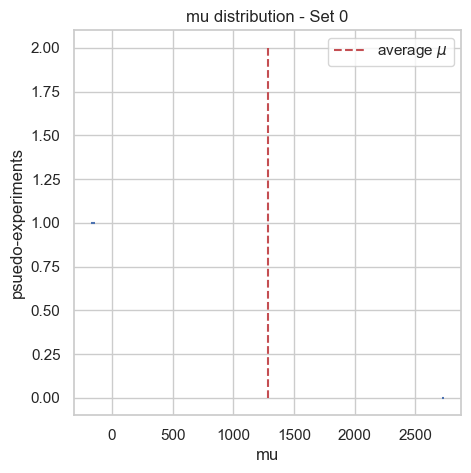

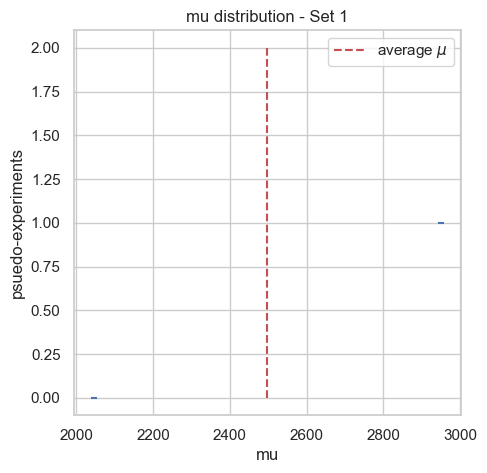

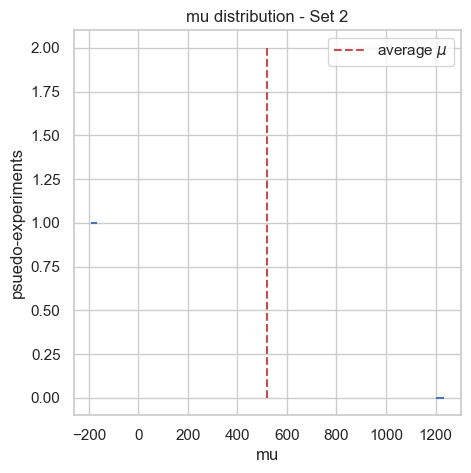

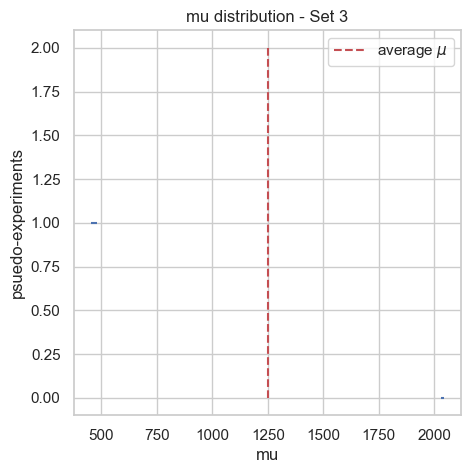

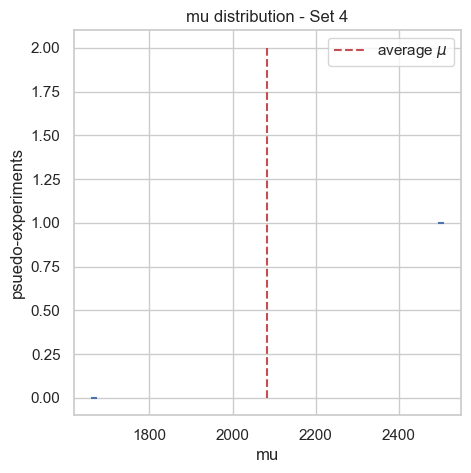

In [ ]:
# Compute Score
score.compute_scores(test_settings)

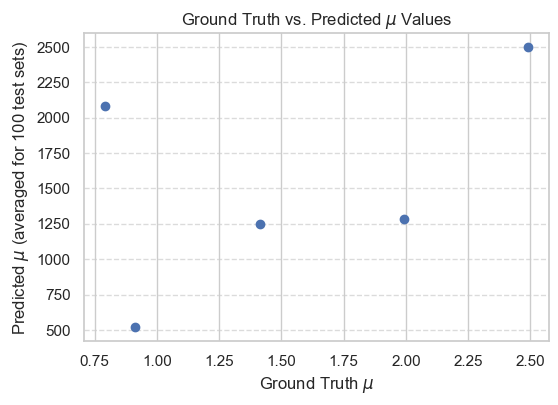

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

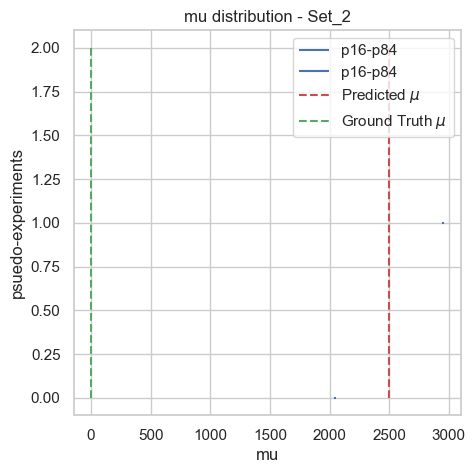

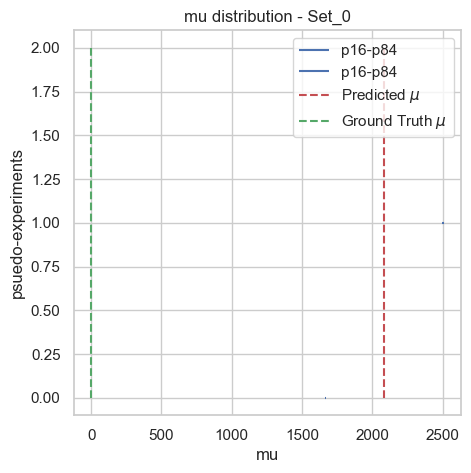

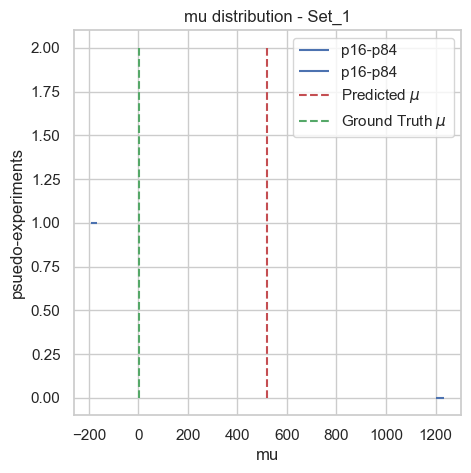

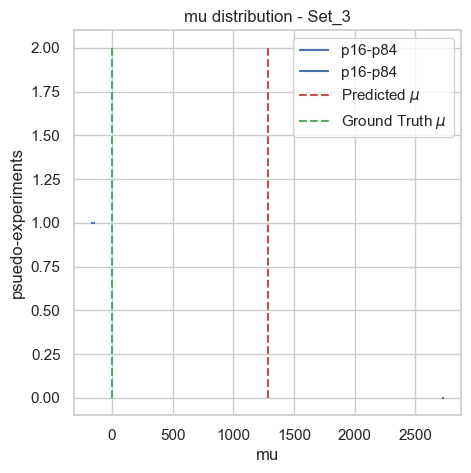

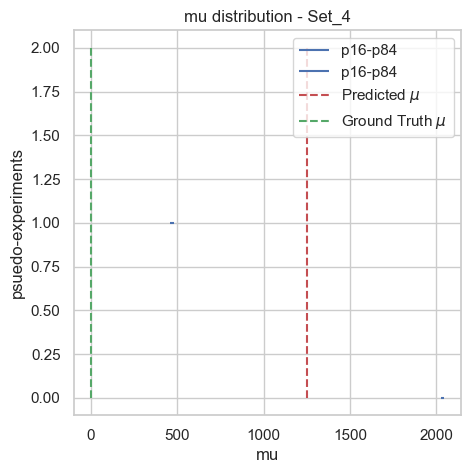

In [ ]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**
⚠️ Note: Ingestion program runs by default a small dataset. To run it on public data set `USE_PUBLIC_DATA = True`

In [ ]:
!python3 $program_dir/run_ingestion.py

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575097 entries, 0 to 575096
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(23), float64(5)
memory usage: 72.4 MB
None
[*] Train data loaded successfully
[*] Calling fit method of submitted model
[*] - Generating Validation sets
   diboson   2406557.155900697
   htautau   285.4728755059505
   ttbar   616020.9338114334
   wjets   3813046.6129843956
   ztautau   7307433.686247317
Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_n_jets', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'PRI_met', 'PRI_met_phi', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep',

### **Test Scoring Program**

In [ ]:
!python3 $score_dir/run_scoring.py

[*] Reading ingestion duration
[✔]
/home/chakkappai/Work/Fair-Universe/HEP-Challenge/sample_result_submission
[*] Reading predictions
[✔]
[*] Computing scores
[*]  [{'mu_hats': [1333.6444189831695, -201.39841864526744], 'delta_mu_hats': [14.133022658969821, 10.578328354505757], 'p16': [1326.5779076536846, -206.6875828225203], 'p84': [1340.7109303126545, -196.10925446801457]}, {'mu_hats': [-486.5543574214785, 1836.8025484809307], 'delta_mu_hats': [9.70334472293166, 14.841899274162188], 'p16': [-491.40602978294436, 1829.3815988438496], 'p84': [-481.7026850600127, 1844.2234981180118]}, {'mu_hats': [1275.8871624297972, 784.5869246618398], 'delta_mu_hats': [13.694079948995295, 14.699241748829309], 'p16': [1269.0401224552995, 777.2373037874252], 'p84': [1282.7342024042948, 791.9365455362545]}, {'mu_hats': [594.890077322394, 476.14318813341424], 'delta_mu_hats': [16.58715845756592, 12.133479003561888], 'p16': [586.596498093611, 470.0764486316333], 'p84': [603.1836565511769, 482.2099276351952]

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : HiggsML-code_submission_24-05-16-19-28.zip to the competition
You can find the zip file in `HEP-Challenge/
